In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import prophet

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [4]:
df = pd.read_csv("energydata_complete.csv ")

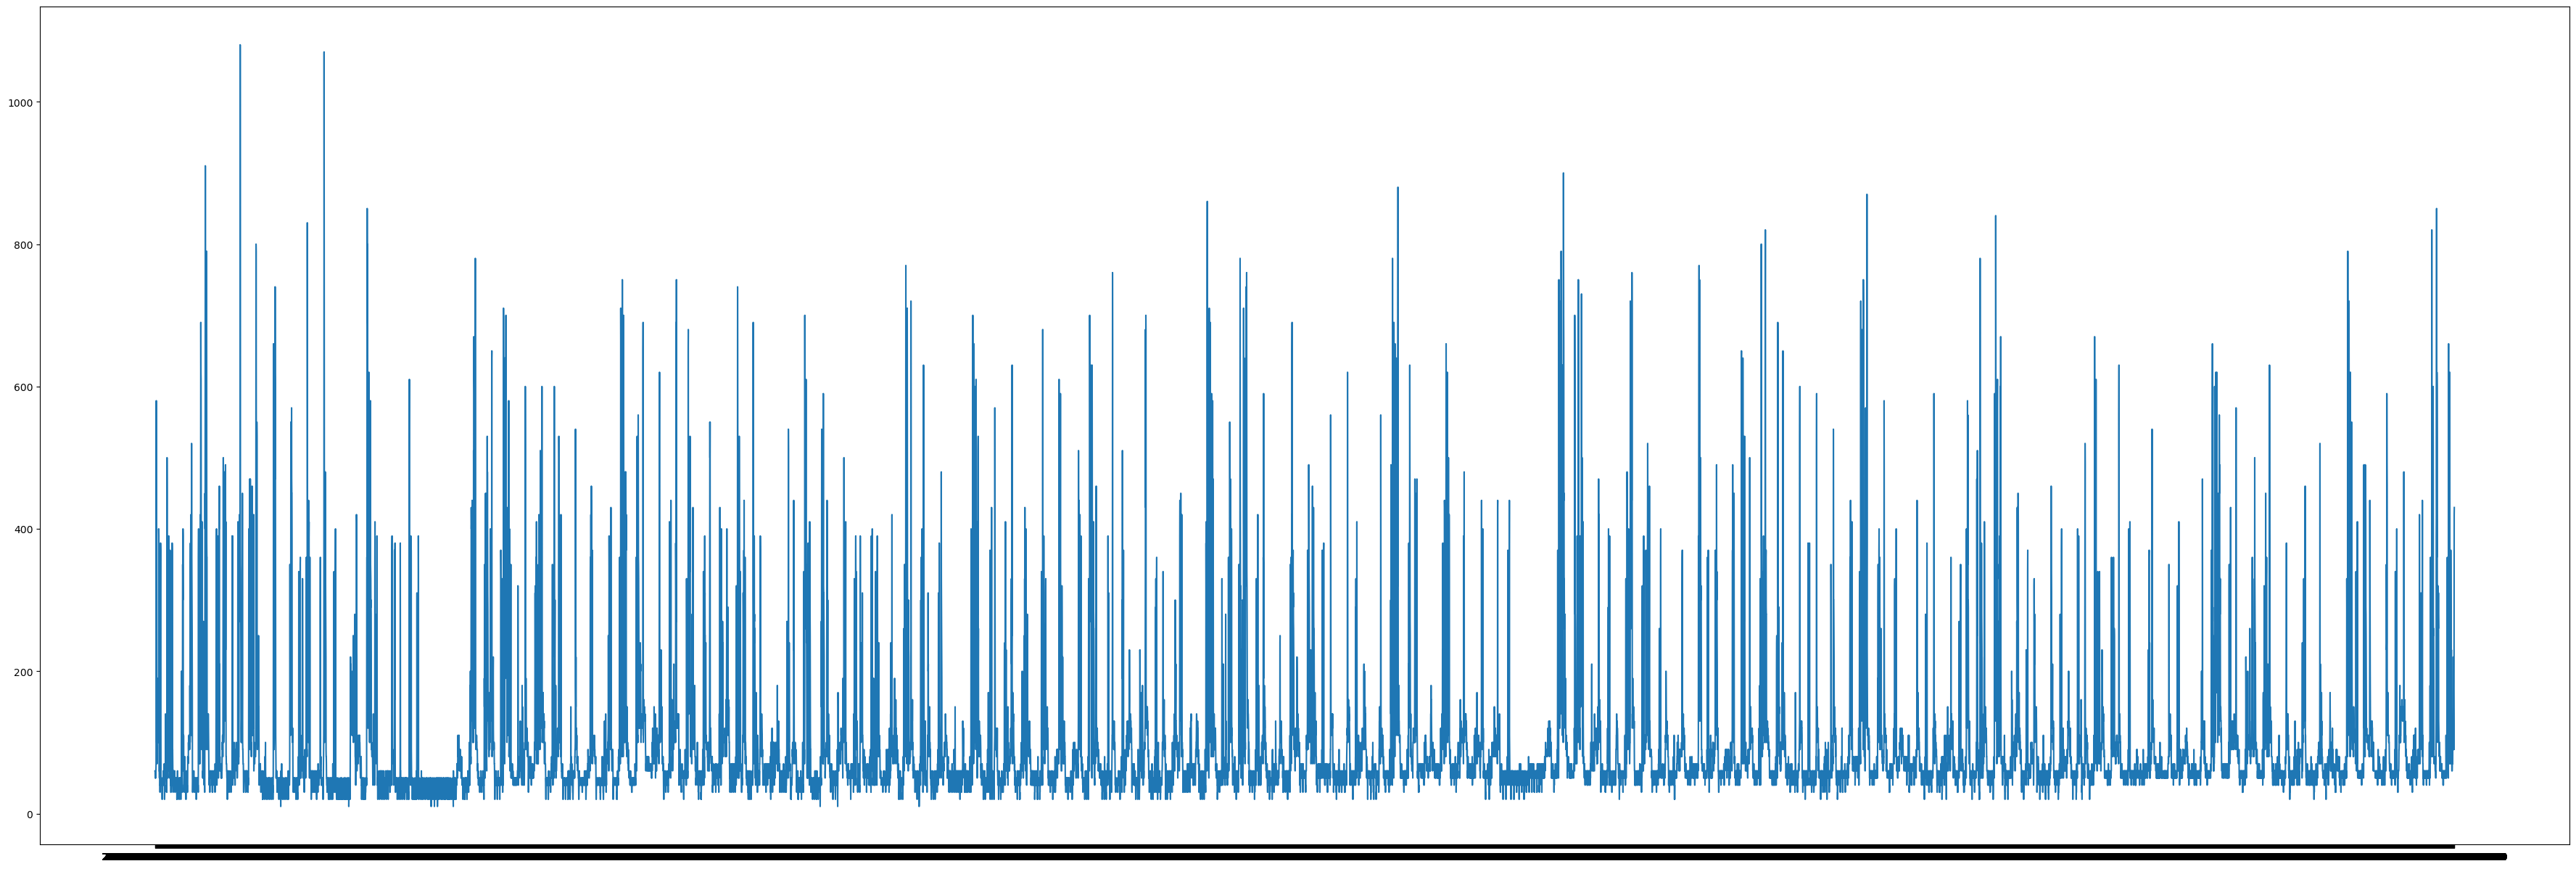

In [5]:
## ploting the trend of appliance's energy use vs time
plt.figure(figsize = (45,15))
plt.plot(df['date'], df['Appliances'])
plt.show()

T1


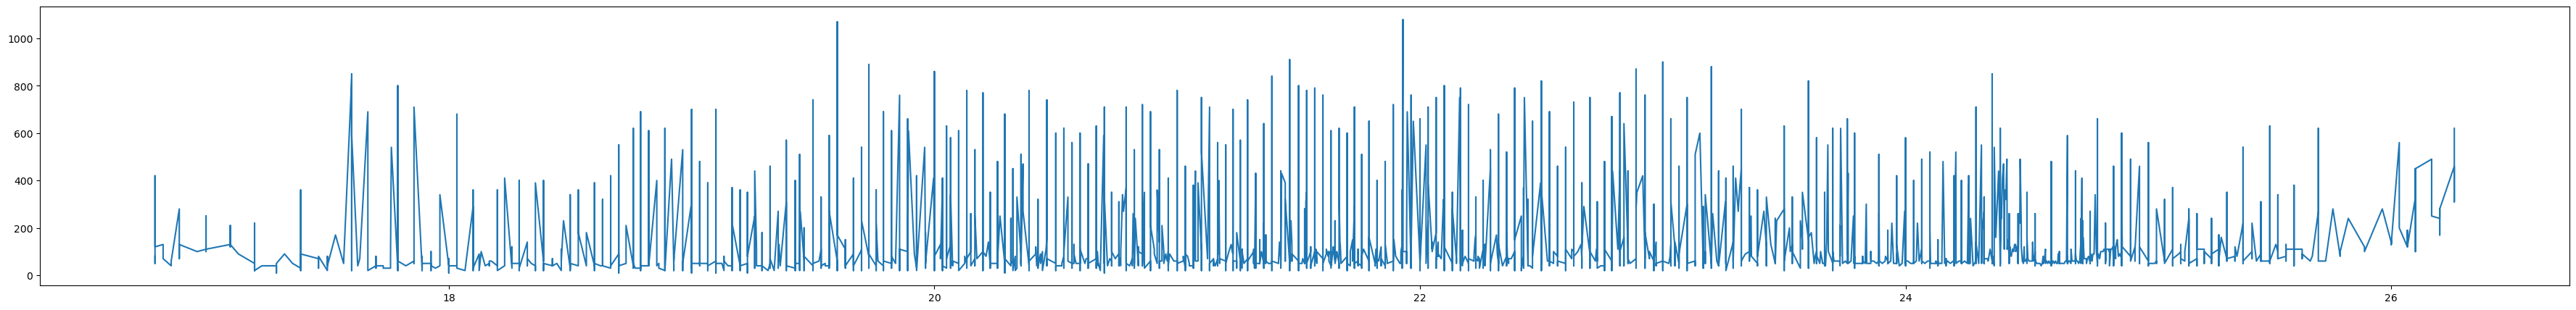

T2


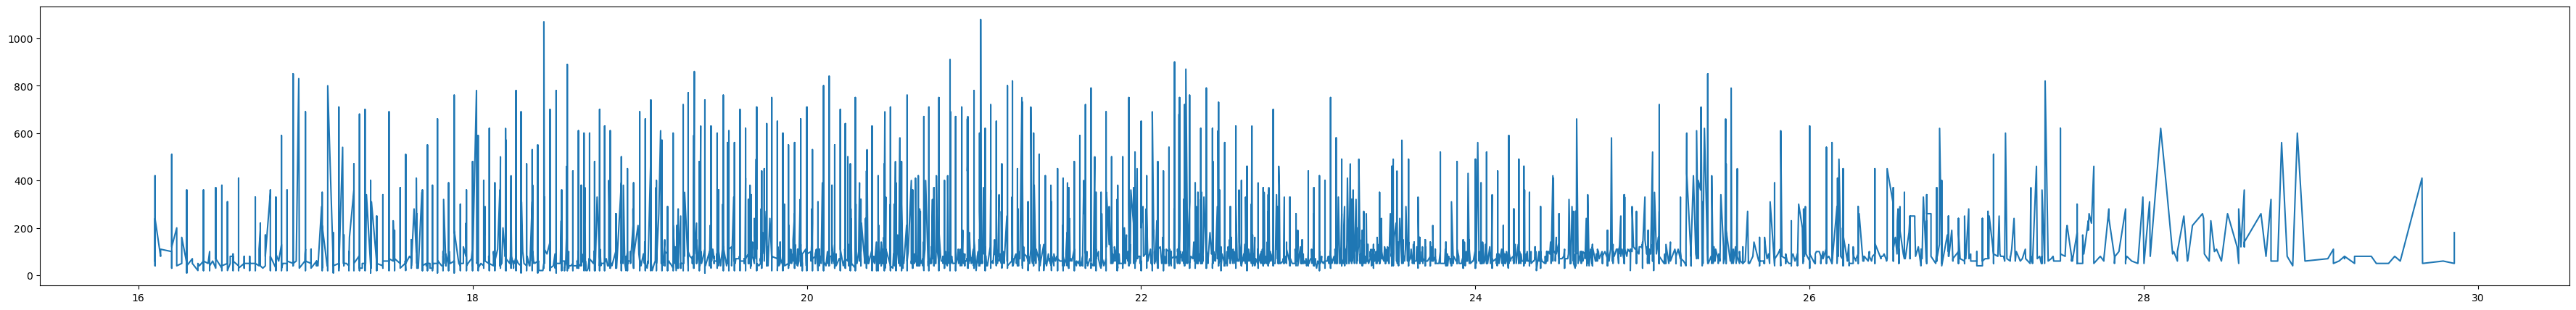

T3


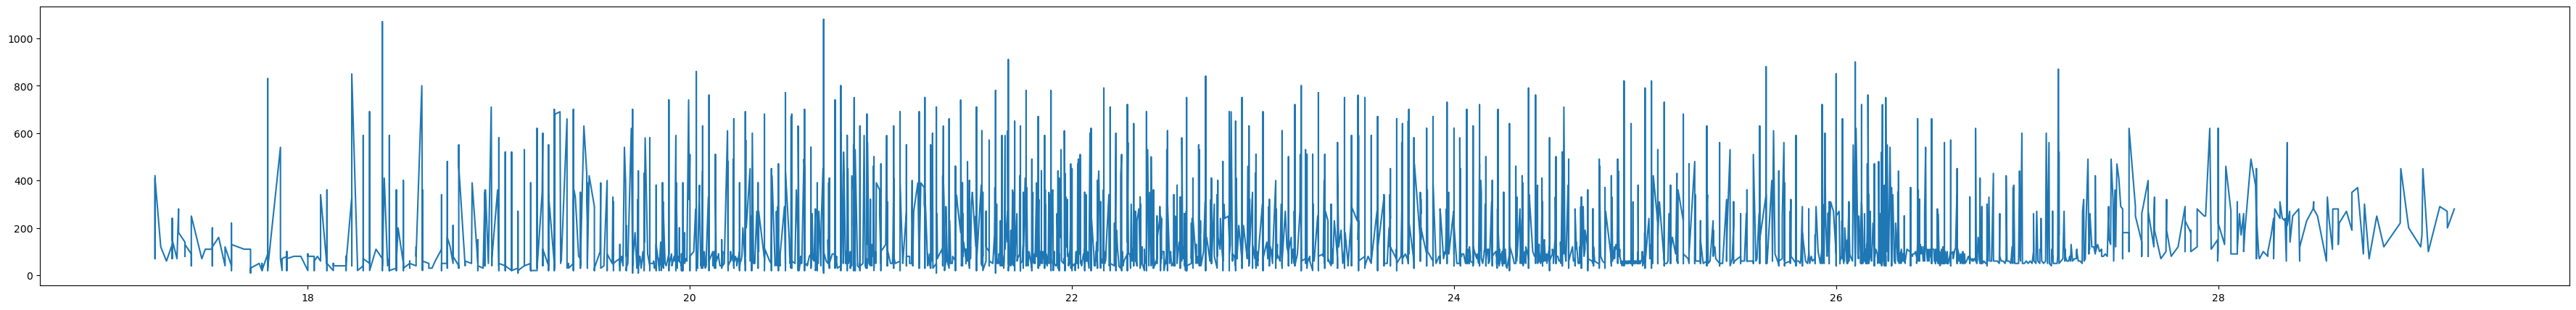

T4


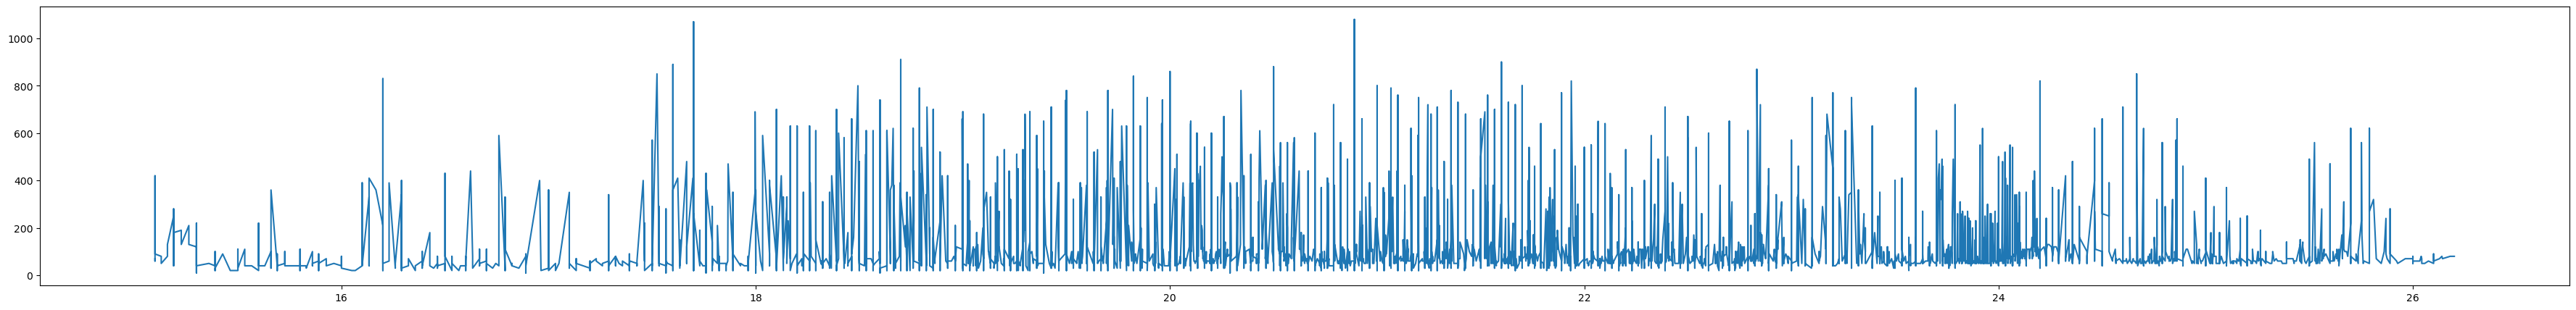

T5


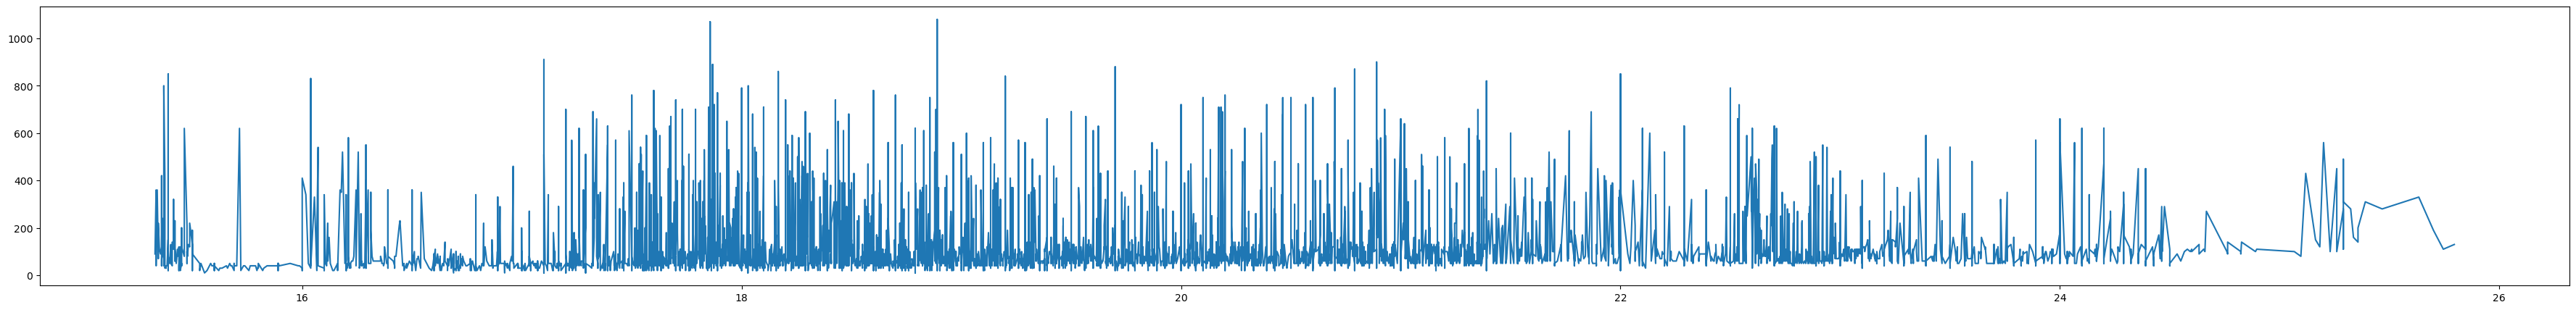

T6


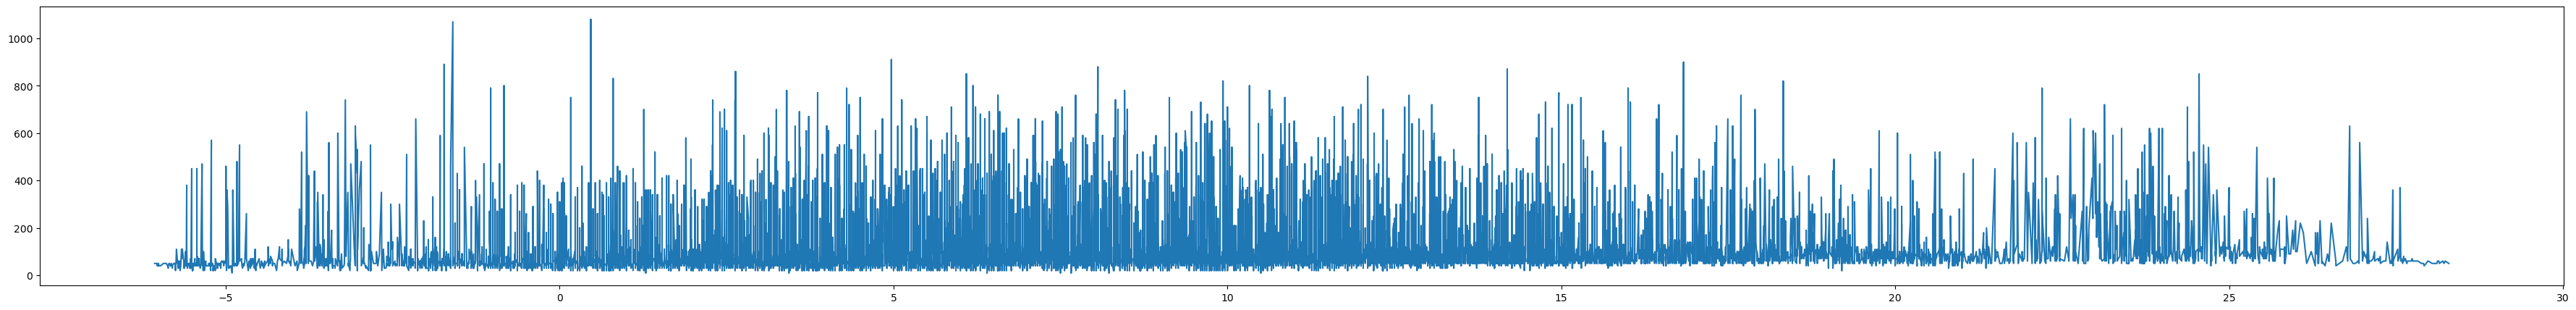

T7


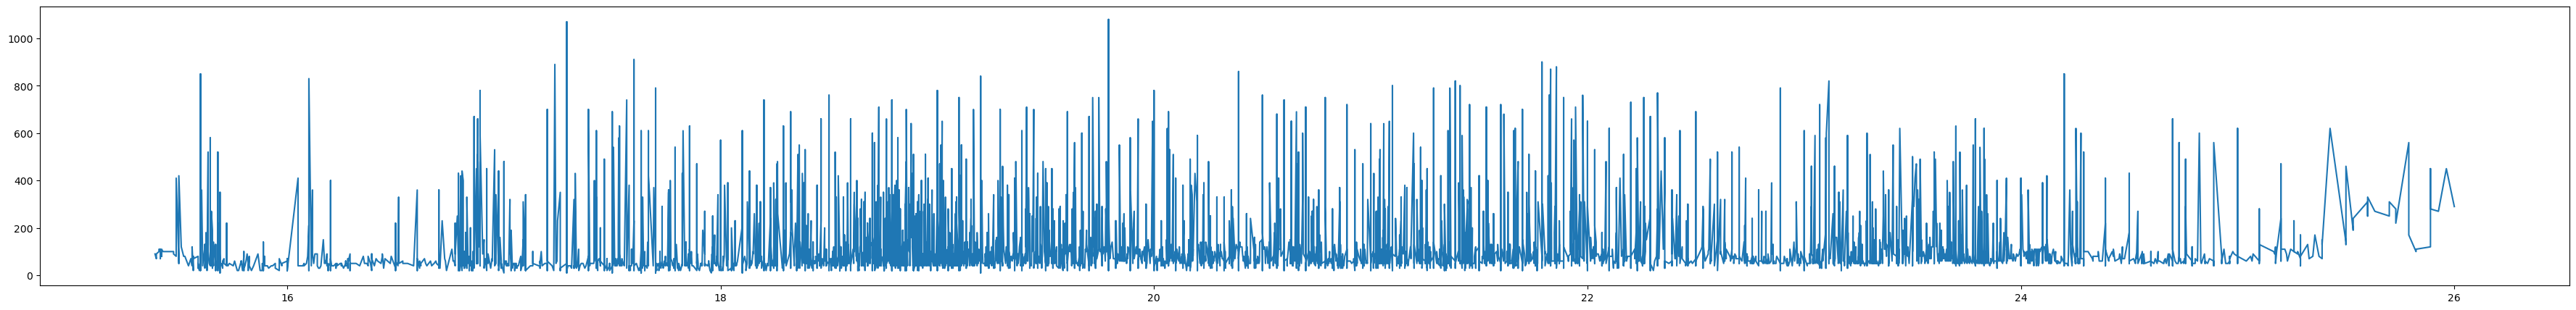

T8


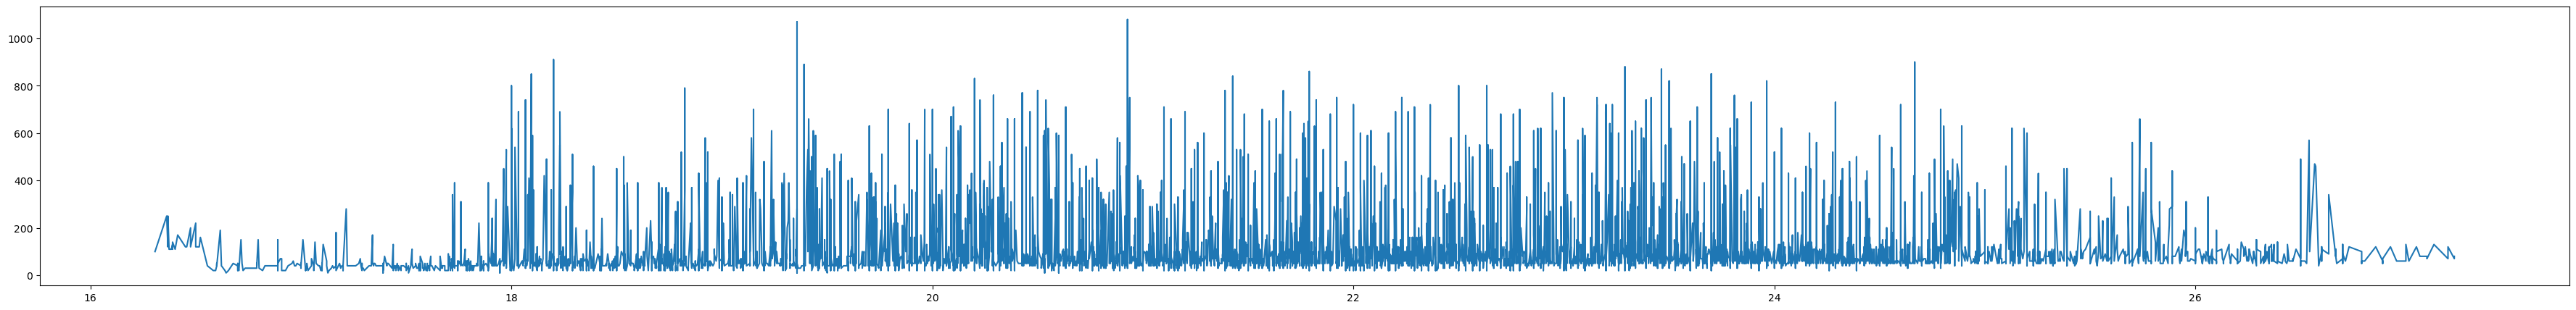

T9


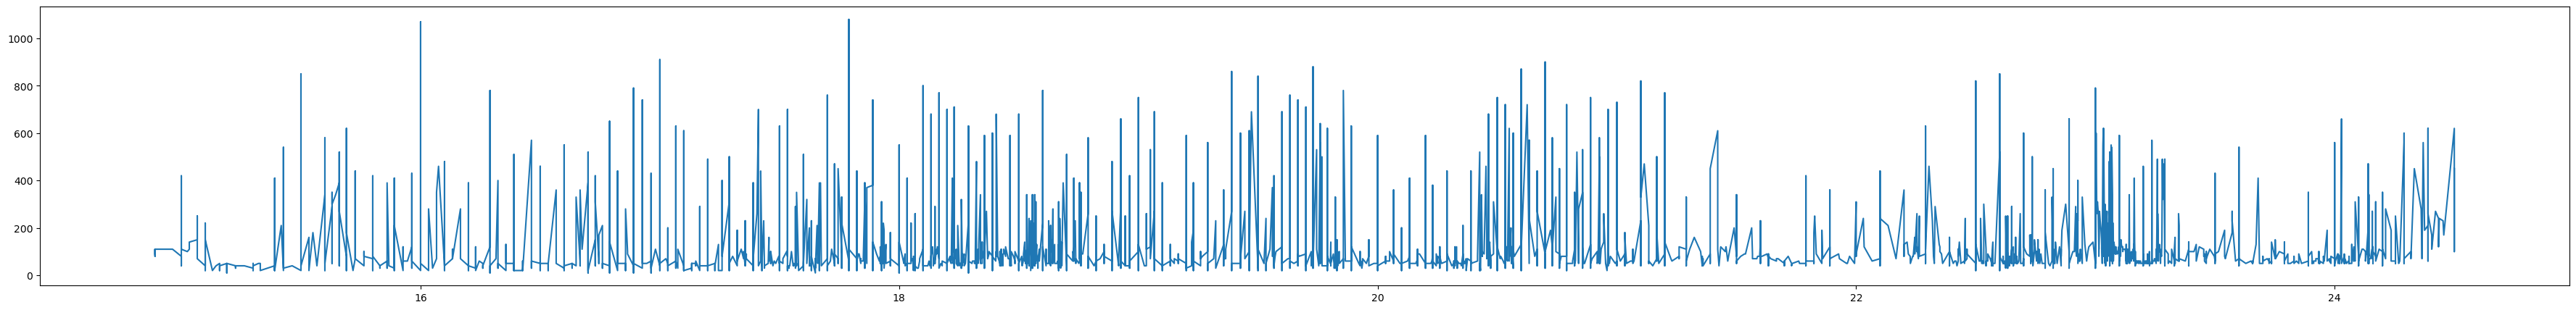

In [6]:
# Temperature
for i in range(1,10):
    print(f'T{i}')
    df_sorted = df.sort_values(by=f'T{i}')
    plt.figure(figsize = (45,5))
    plt.plot(df_sorted[f'T{i}'], df_sorted['Appliances'])
    plt.show()

RH_1


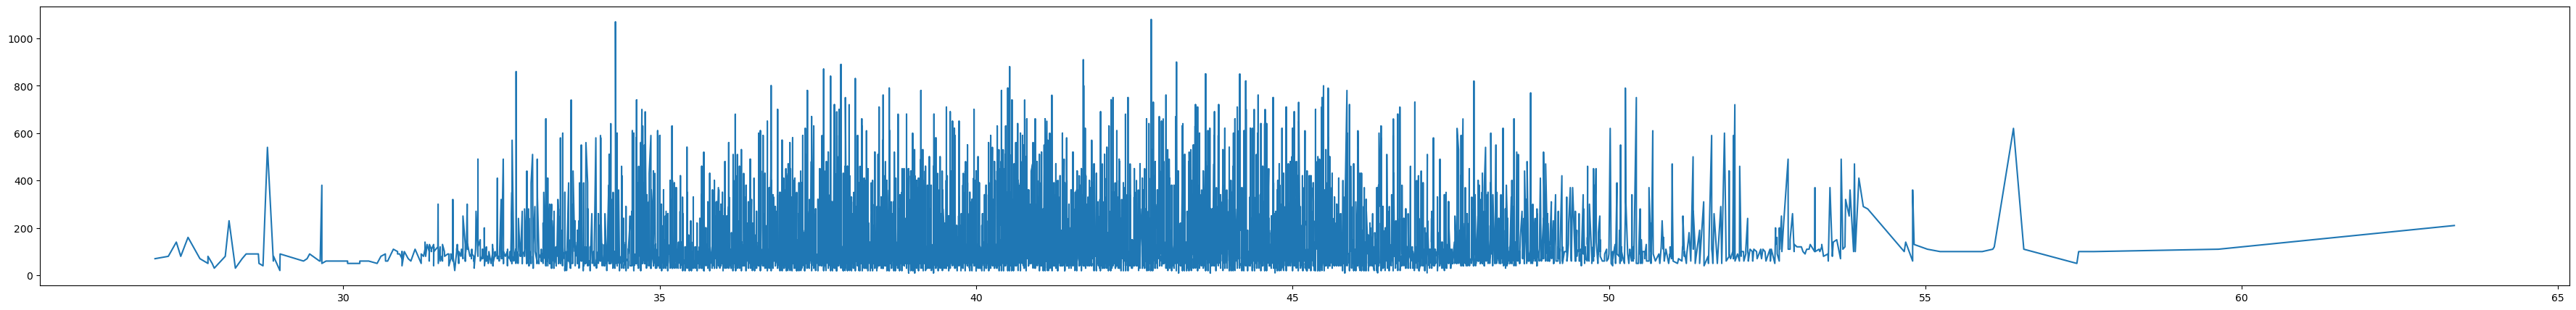

RH_2


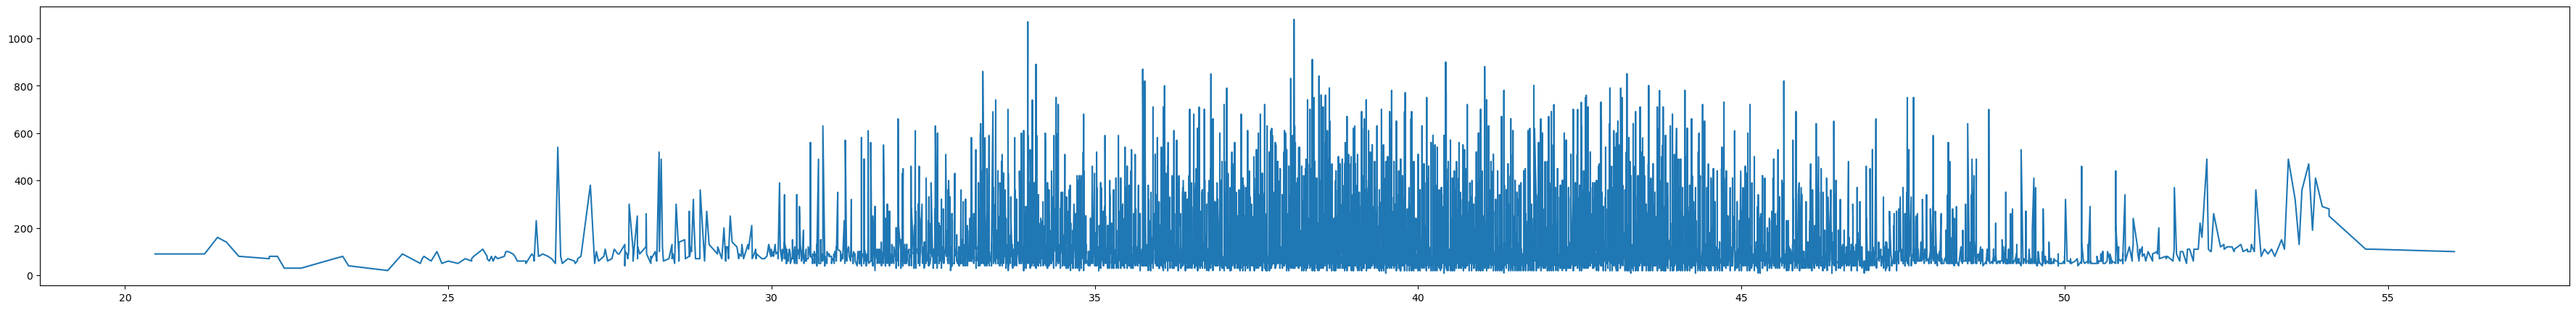

RH_3


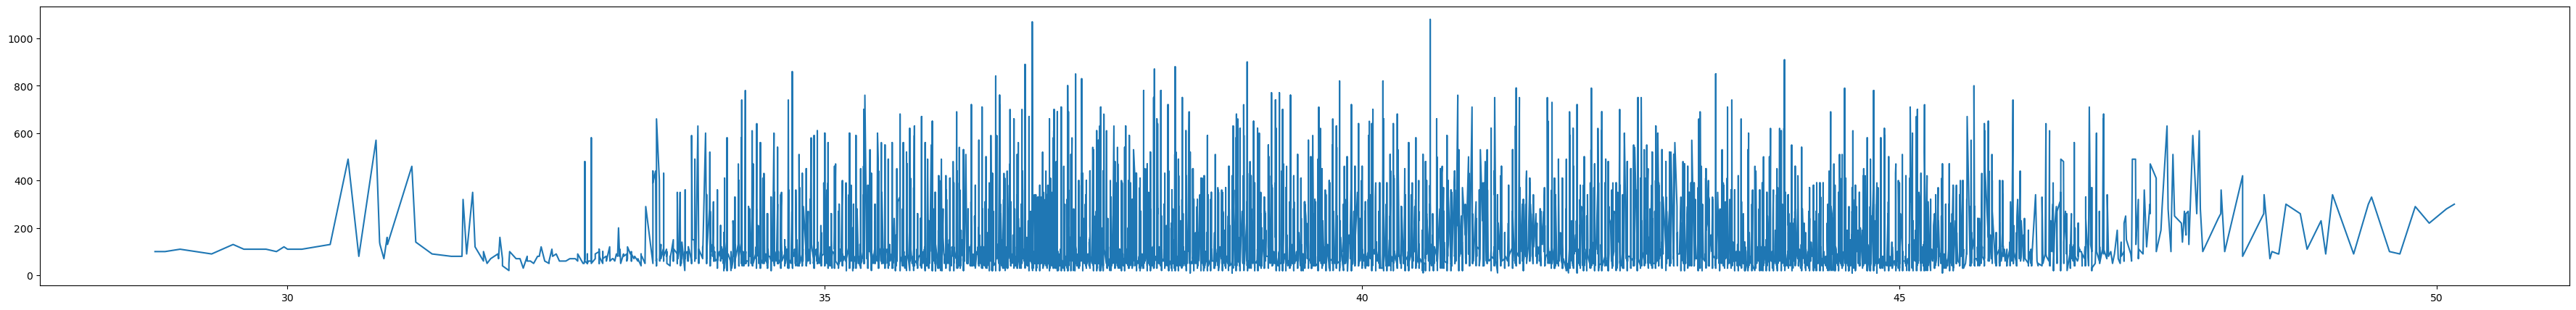

RH_4


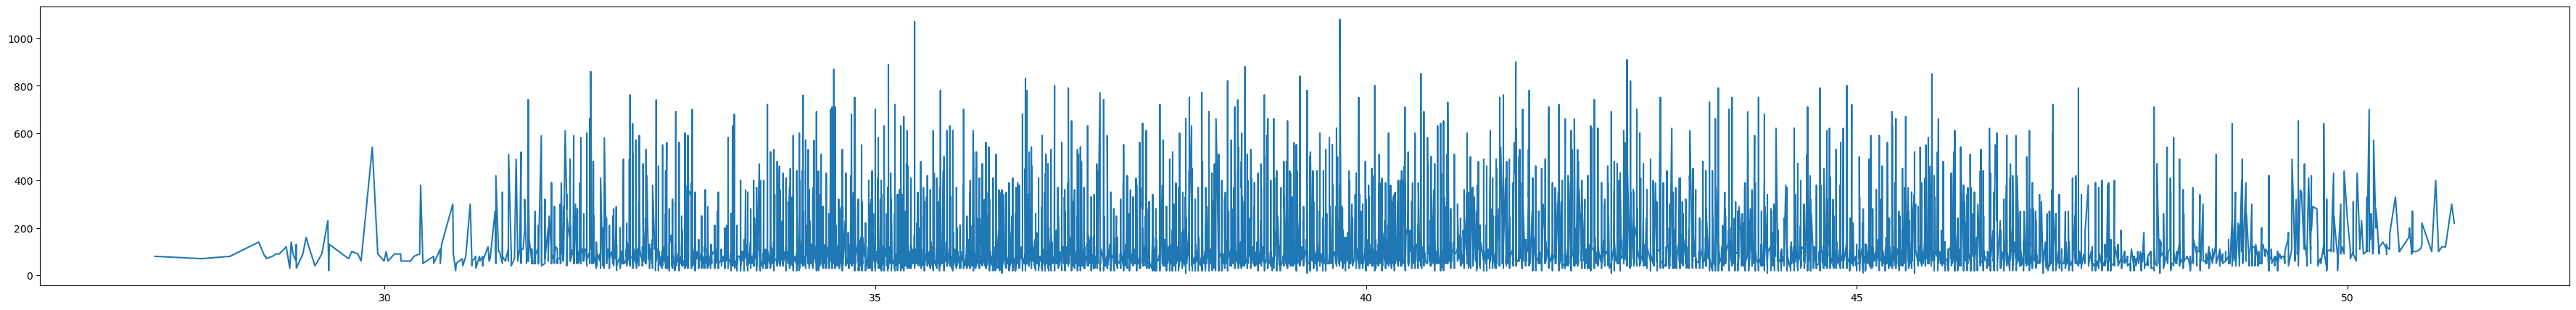

RH_5


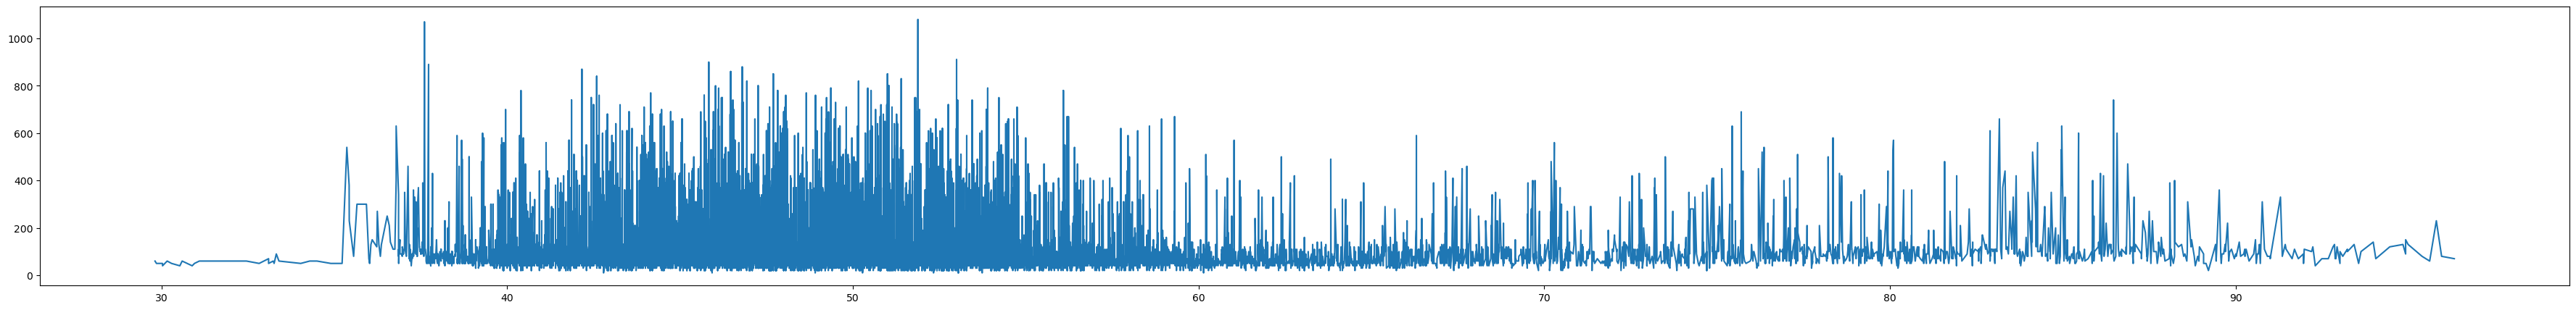

RH_6


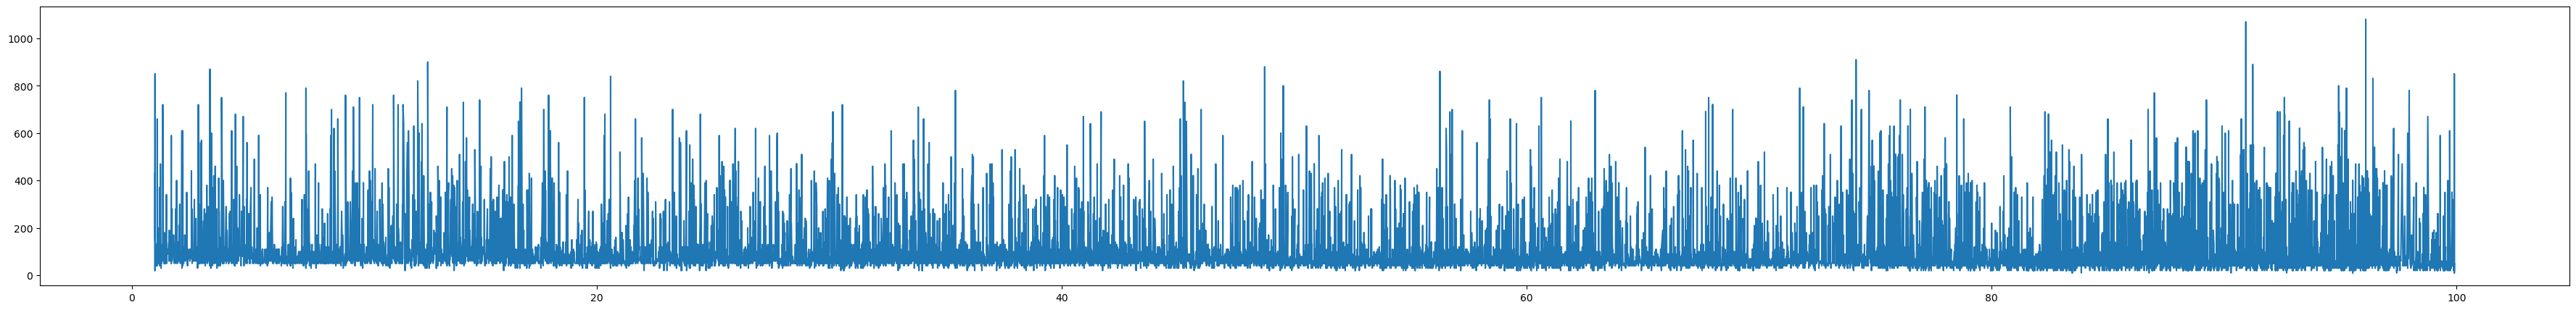

RH_7


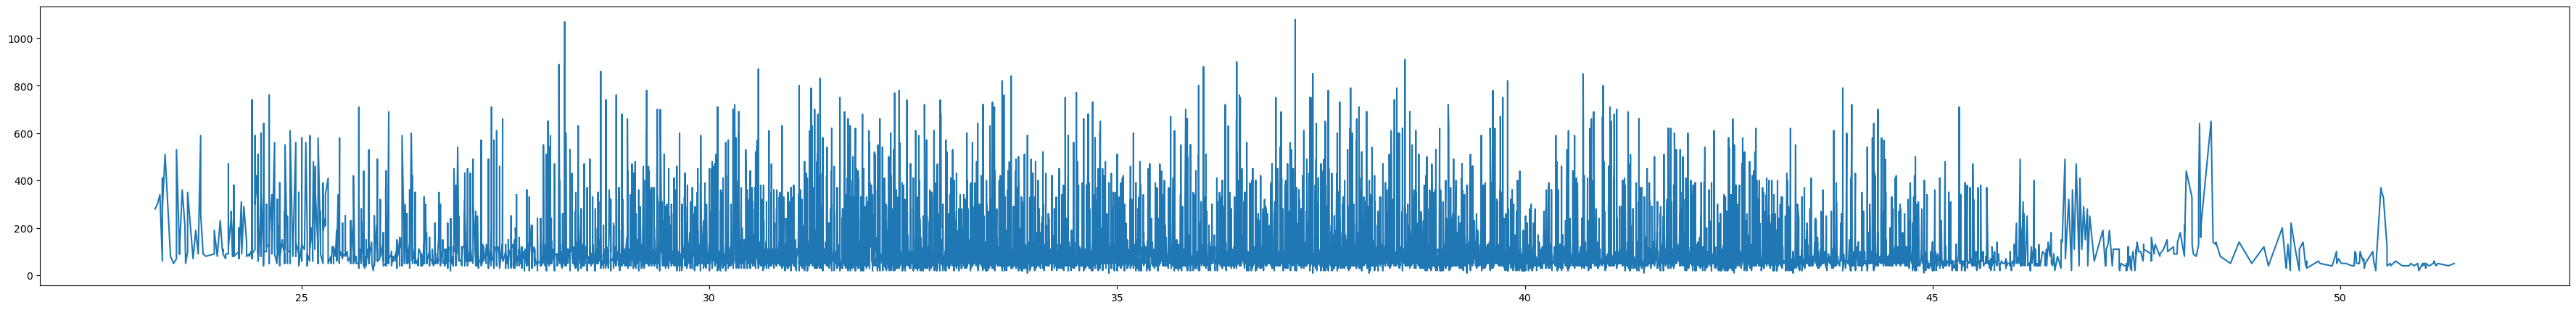

RH_8


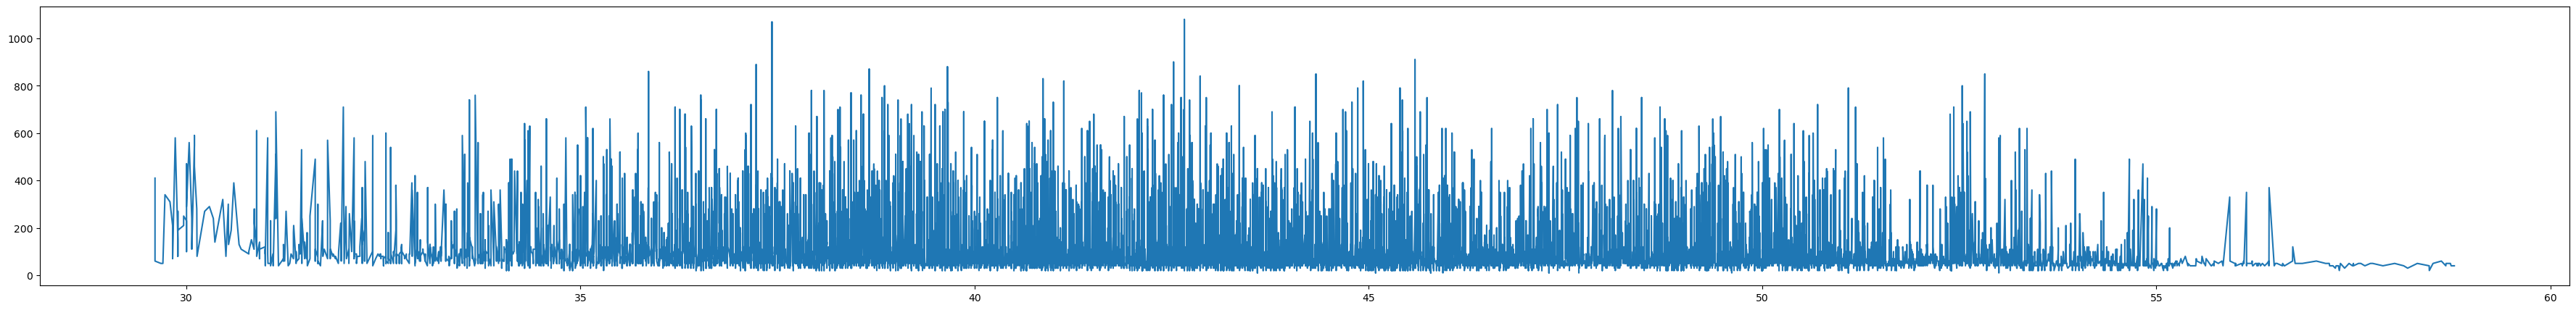

RH_9


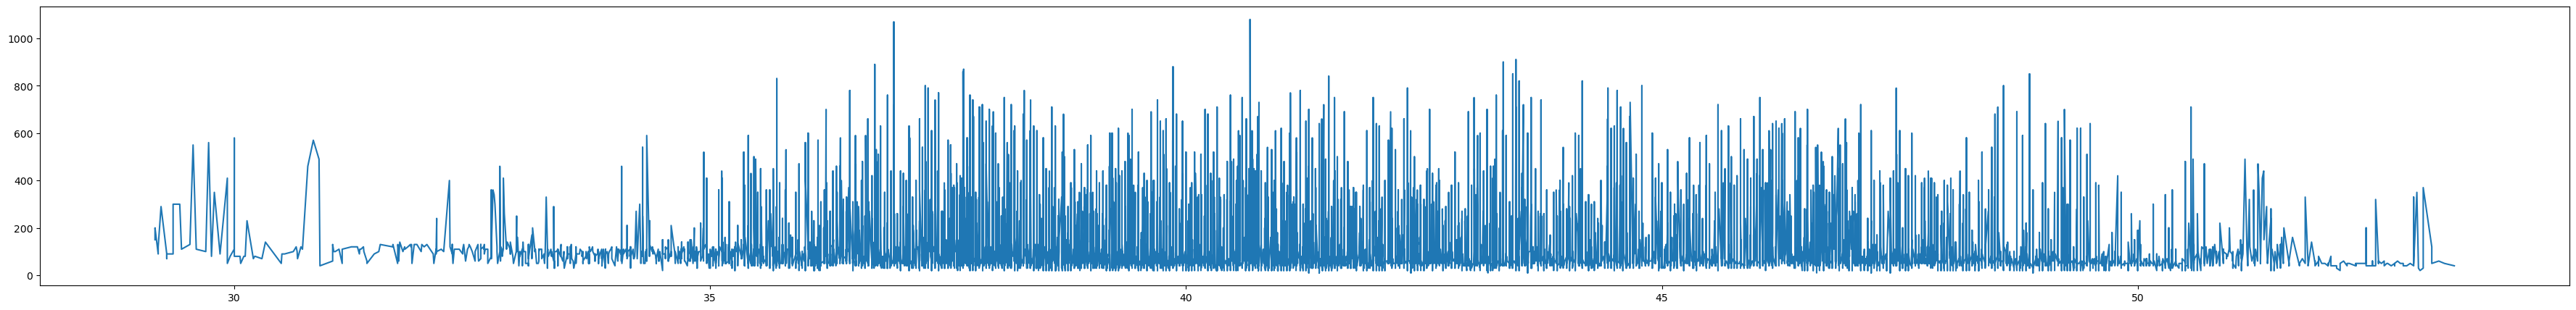

In [7]:
# Relative Humidity
for i in range(1,10):
    print(f'RH_{i}')
    df_sorted = df.sort_values(by=f'RH_{i}')
    plt.figure(figsize = (45,5))
    plt.plot(df_sorted[f'RH_{i}'], df_sorted['Appliances'])
    plt.show()


In [9]:
df_ = df.copy()
df_['ds'] = pd.to_datetime(df_['date'])
df_['minute'] = df_['ds'].dt.minute
df_ = df_[df_['minute' ]==0]
df_.drop(['date', 'minute'], axis =1, inplace = True)

In [11]:
X = df_.drop([ 'ds','Appliances', 'lights'], axis = 1)
scalar = StandardScaler()
scaled_data = scalar.fit_transform(X)
pca = PCA(n_components = 7)
pca.fit(scaled_data)
X_ = pca.transform(scaled_data)
# new_columns = ['rv1', 'rv2', 'rv3', 'rv4', 'rv5', 'rv6', 'rv7', 'rv8', 'rv9']
new_columns = [f'rv{n}' for n in range(1, 8)]

df_k = pd.DataFrame(X_, columns=new_columns)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.35794254 0.27080749 0.0772082  0.06969238 0.04036846 0.03765629
 0.03637621]


In [12]:
Y = df_[['ds', 'Appliances',]]
df_new = pd.concat([Y.reset_index(drop = True), df_k.reset_index(drop = True)], axis =1)
df_new.shape


(3290, 9)

In [14]:
df_new['ds'] =  pd.to_datetime(df_new['ds'])

In [16]:
df_train = df_new[df_new['ds']<'2016-05-15 17:00:00']
df_test  = df_new[df_new['ds']>='2016-05-15 17:00:00']

C:\Users\HP\AppData\Local\Temp\ipykernel_13652\2718005380.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decompose.plot().show()


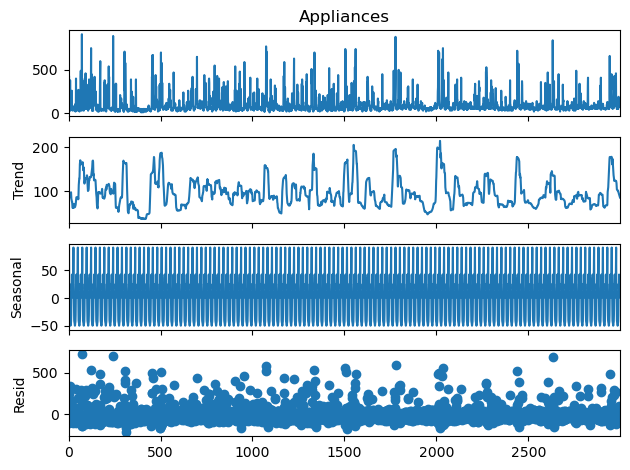

In [18]:
decompose = seasonal_decompose(df_train.Appliances, model = 'Additive', extrapolate_trend = 'freq', period = 24)
decompose.plot().show()

In [19]:
df_train_prophet = df_train
print(df_train_prophet.columns)
df_train_prophet = df_train_prophet.rename(columns={"date": "ds"})
df_train_prophet = df_train_prophet.rename(columns={"Appliances": "y"})

Index(['ds', 'Appliances', 'rv1', 'rv2', 'rv3', 'rv4', 'rv5', 'rv6', 'rv7'], dtype='object')


In [20]:

model_prophet  =  Prophet(
    changepoint_prior_scale=0.05,  
    seasonality_prior_scale=11,    
    holidays_prior_scale=15,       
    seasonality_mode='additive',   
    yearly_seasonality= True,       
    weekly_seasonality=  True,       
    daily_seasonality=  True        
)
model_prophet.fit(df_train_prophet)

15:30:27 - cmdstanpy - INFO - Chain [1] start processing
15:30:27 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
timestamp1 = datetime.strptime('2016-05-15 17:00:00', '%Y-%m-%d %H:%M:%S')
timestamp2 = datetime.strptime('2016-05-27 18:00:00', '%Y-%m-%d %H:%M:%S')

# Calculate the time difference
time_difference = timestamp2 - timestamp1
print(time_difference)
# Convert time difference to hours and minutes
hours = time_difference.seconds // 3600
minutes = (time_difference.seconds // 60) % 60

print(f'Time difference: {hours} hours {minutes} minutes')

12 days, 1:00:00
Time difference: 1 hours 0 minutes


In [22]:
period = (12*24)+2
df_future = model_prophet.make_future_dataframe(freq = 'H', periods = period, include_history = False)
# fcst = model_prophet.predict(df_future)

In [23]:
# z = df_test[['rv1', 'rv2', 'rv3', 'rv4', 'rv5', 'rv6']]
# z.reset_index(drop = True, inplace = True)
# df_future_ = pd.concat([df_future, z], axis= 1)
# df_future_.columns

In [24]:
df_future_ = df_future.copy()

In [25]:
forecast_prophet = model_prophet.predict(df_future_)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()
forecast_prophet.reset_index(drop = True)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0   2016-05-15 17:00:00  114.422797   25.672950  262.522052   114.422797   
1   2016-05-15 18:00:00  114.437069   60.581620  291.075770   114.437069   
2   2016-05-15 19:00:00  114.451340   62.876847  301.097839   114.451340   
3   2016-05-15 20:00:00  114.465612   44.850717  281.217957   114.465612   
4   2016-05-15 21:00:00  114.479884   12.085182  257.887030   114.479884   
..                  ...         ...         ...         ...          ...   
285 2016-05-27 14:00:00  118.490290   37.354827  293.938882   118.489840   
286 2016-05-27 15:00:00  118.504562   36.126814  281.518106   118.504110   
287 2016-05-27 16:00:00  118.518833   45.185486  288.127681   118.518380   
288 2016-05-27 17:00:00  118.533105   72.739161  318.403696   118.532649   
289 2016-05-27 18:00:00  118.547377  101.861731  341.008039   118.546918   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     114.422797       35.485654             35.485654             35.485654   
1     114.437069       61.357342             61.357342             61.357342   
2     114.451340       69.965082             69.965082             69.965082   
3     114.465612       53.169177             53.169177             53.169177   
4     114.479884       18.859281             18.859281             18.859281   
..           ...             ...                   ...                   ...   
285   118.490772       48.482964             48.482964             48.482964   
286   118.505047       40.112768             40.112768             40.112768   
287   118.519321       49.108842             49.108842             49.108842   
288   118.533595       73.772786             73.772786             73.772786   
289   118.547869       99.261930             99.261930             99.261930   

         daily  ...     weekly  weekly_lower  weekly_upper     yearly  \
0    36.613971  ...  -0.351685     -0.351685     -0.351685  -0.776633   
1    61.596890  ...   0.381003      0.381003      0.381003  -0.620551   
2    69.289540  ...   1.139955      1.139955      1.139955  -0.464414   
3    51.561768  ...   1.915636      1.915636      1.915636  -0.308227   
4    16.312977  ...   2.698300      2.698300      2.698300  -0.151996   
..         ...  ...        ...           ...           ...        ...   
285  13.191637  ...   8.854665      8.854665      8.854665  26.436661   
286   4.147641  ...   9.546434      9.546434      9.546434  26.418693   
287  12.518863  ...  10.190224     10.190224     10.190224  26.399755   
288  36.613971  ...  10.778967     10.778967     10.778967  26.379848   
289  61.596890  ...  11.306068     11.306068     11.306068  26.358973   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -0.776633     -0.776633                   0.0   
1       -0.620551     -0.620551                   0.0   
2       -0.464414     -0.464414                   0.0   
3       -0.308227     -0.308227                   0.0   
4       -0.151996     -0.151996                   0.0   
..            ...           ...                   ...   
285     26.436661     26.436661                   0.0   
286     26.418693     26.418693                   0.0   
287     26.399755     26.399755                   0.0   
288     26.379848     26.379848                   0.0   
289     26.358973     26.358973                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0  149.908450  
1                           0.0                         0.0  175.794410  
2                           0.0                         0.0  184.416422  
3                           0.0                         0.0  167.634789  
4                           0.0                         0.0  133.339165  
..                          ...                         ...         ...  
285                         0.0                         0.0  166.97

C:\Users\HP\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\HP\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\HP\AppData\Local\Temp\ipykernel_13652\2880403500.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

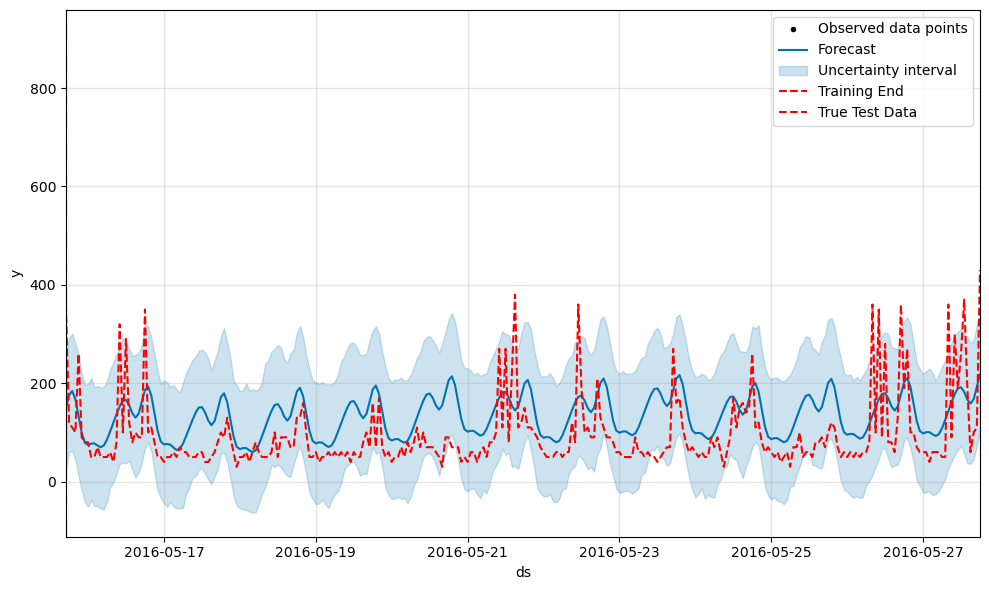

In [26]:
forecast_plot = model_prophet.plot(forecast_prophet)
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-period]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')
df_test['ds'] = pd.to_datetime(df_test['ds'])
plt.plot(df_test['ds'], df_test['Appliances'],  label='True Test Data',color = 'red', linestyle="--")
plt.xlim('2016-05-15 17:00:00', '2016-05-27 18:00:00')
plt.legend()

In [27]:
df_test.reset_index(drop = True, inplace = True)
forecast_prophet.reset_index(drop = True, inplace = True)

In [28]:
N_accurate = df_test[(df_test['Appliances'].astype(float)<forecast_prophet['yhat_upper'].astype(float)) & (df_test['Appliances'].astype(float) > forecast_prophet['yhat_lower'].astype(float))].shape[0]

In [29]:
N = df_test.shape[0]

In [30]:
accuracy = N_accurate/N  * 100
print("accuracy on test data: ", accuracy)

accuracy on test data:  92.06896551724138


In [31]:
period = (12*24)+2+40
df_future = model_prophet.make_future_dataframe(freq = 'H', periods = period, include_history = False)

In [32]:
z = df_test[['rv1', 'rv2', 'rv3', 'rv4', 'rv5', 'rv6']]
z.reset_index(drop = True, inplace = True)
df_future_ = pd.concat([df_future, z], axis= 1)
df_future_.columns

Index(['ds', 'rv1', 'rv2', 'rv3', 'rv4', 'rv5', 'rv6'], dtype='object')

In [33]:
forecast_prophet_new = model_prophet.predict(df_future_)
forecast_prophet_new[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()
forecast_prophet_new.reset_index(drop = True)

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0   2016-05-15 17:00:00  114.422797   31.246224  264.657623   114.422797   
1   2016-05-15 18:00:00  114.437069   57.096959  300.100352   114.437069   
2   2016-05-15 19:00:00  114.451340   66.736309  295.417108   114.451340   
3   2016-05-15 20:00:00  114.465612   48.132473  286.371748   114.465612   
4   2016-05-15 21:00:00  114.479884   17.799120  262.787964   114.479884   
..                  ...         ...         ...         ...          ...   
325 2016-05-29 06:00:00  119.061166  -23.775986  219.615973   119.060607   
326 2016-05-29 07:00:00  119.075438   -5.306846  239.012468   119.074876   
327 2016-05-29 08:00:00  119.089710   11.146888  254.545399   119.089145   
328 2016-05-29 09:00:00  119.103982   30.985723  274.223316   119.103413   
329 2016-05-29 10:00:00  119.118253   46.065304  292.202660   119.117682   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0     114.422797       35.485654             35.485654             35.485654   
1     114.437069       61.357342             61.357342             61.357342   
2     114.451340       69.965082             69.965082             69.965082   
3     114.465612       53.169177             53.169177             53.169177   
4     114.479884       18.859281             18.859281             18.859281   
..           ...             ...                   ...                   ...   
325   119.061720      -18.454104            -18.454104            -18.454104   
326   119.075994       -2.291847             -2.291847             -2.291847   
327   119.090269       15.008690             15.008690             15.008690   
328   119.104545       31.913283             31.913283             31.913283   
329   119.118816       47.686755             47.686755             47.686755   

         daily  ...    weekly  weekly_lower  weekly_upper     yearly  \
0    36.613971  ... -0.351685     -0.351685     -0.351685  -0.776633   
1    61.596890  ...  0.381003      0.381003      0.381003  -0.620551   
2    69.289540  ...  1.139955      1.139955      1.139955  -0.464414   
3    51.561768  ...  1.915636      1.915636      1.915636  -0.308227   
4    16.312977  ...  2.698300      2.698300      2.698300  -0.151996   
..         ...  ...       ...           ...           ...        ...   
325 -38.962660  ... -4.463899     -4.463899     -4.463899  24.972455   
326 -22.717995  ... -4.490511     -4.490511     -4.490511  24.916659   
327  -5.424166  ... -4.427097     -4.427097     -4.427097  24.859953   
328  11.385949  ... -4.275006     -4.275006     -4.275006  24.802340   
329  26.979555  ... -4.036621     -4.036621     -4.036621  24.743821   

     yearly_lower  yearly_upper  multiplicative_terms  \
0       -0.776633     -0.776633                   0.0   
1       -0.620551     -0.620551                   0.0   
2       -0.464414     -0.464414                   0.0   
3       -0.308227     -0.308227                   0.0   
4       -0.151996     -0.151996                   0.0   
..            ...           ...                   ...   
325     24.972455     24.972455                   0.0   
326     24.916659     24.916659                   0.0   
327     24.859953     24.859953                   0.0   
328     24.802340     24.802340                   0.0   
329     24.743821     24.743821                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0  149.908450  
1                           0.0                         0.0  175.794410  
2                           0.0                         0.0  184.416422  
3                           0.0                         0.0  167.634789  
4                           0.0                         0.0  133.339165  
..                          ...                         ...         ...  
325                         0.0                         0.0  100.607062  
326  

C:\Users\HP\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\HP\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
C:\Users\HP\AppData\Local\Temp\ipykernel_13652\360944892.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

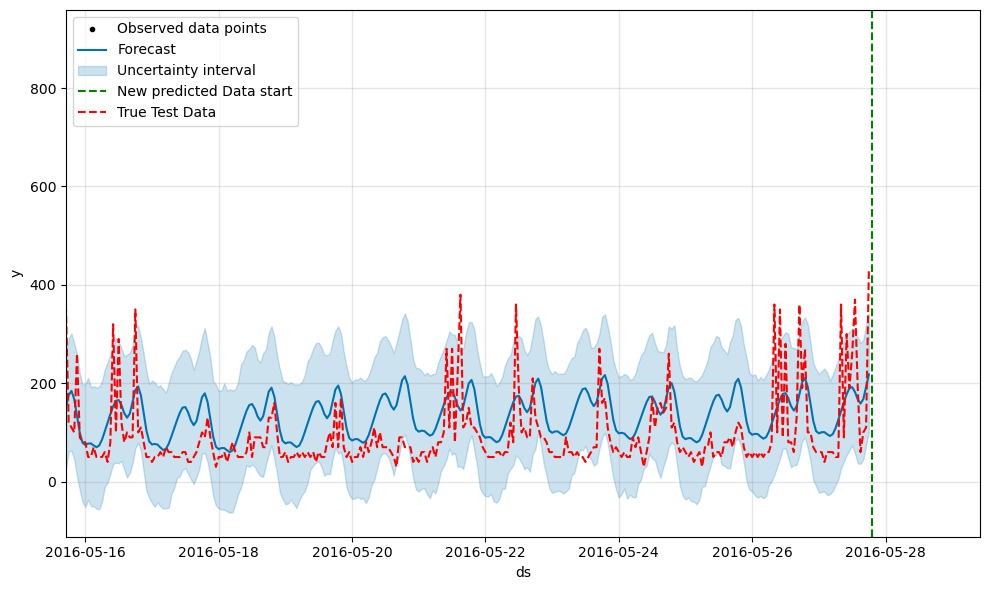

In [34]:
forecast_plot_new = model_prophet.plot(forecast_prophet)
axes = forecast_plot_new.gca()
last_test_date = forecast_prophet_new['ds'].iloc[290]
axes.axvline(x=last_test_date, color='green', linestyle='--', label='New predicted Data start')
df_test['ds'] = pd.to_datetime(df_test['ds'])
plt.plot(df_test['ds'], df_test['Appliances'],  label='True Test Data',color = 'red', linestyle="--")
plt.xlim('2016-05-15 17:00:00', '2016-05-29 10:00:00')
plt.legend()